# Imports

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from datetime import datetime
from datetime import timedelta
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_recall_fscore_support, confusion_matrix,ConfusionMatrixDisplay
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import shap
shap.initjs()

# Data

In [2]:
data = pd.read_csv('dataset_finale.csv', header ='infer').iloc[:,1:]
#data's classes were initially (1,2,3,4) hence change to (0,1,2,3)
data['class']=data['class']-1 

## Feature engineering

In [3]:
data['log(views)/log(com)']=(np.log(2+data['views']))/np.log((2+data['n_comments']))
data['log(com)/log(views)']=(np.log(2+data['n_comments']))/np.log((2+data['views']))

## Duration - minutes only

In [4]:
data['durata']=round(data['durata']/60)

## Titles elaboration

In [5]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import *
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Filippo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
def clean(string):
    tokenizer = RegexpTokenizer(r'\w+')
    string=tokenizer.tokenize(string)
    for word in range(len(string)):
        string[word] = string[word].lower() 
    #Remove stopwords
    string = [word for word in string if not word in stopwords.words()]
    #STEMMING
    stemmer = PorterStemmer()
    string = [stemmer.stem(word) for word in string]
    return " ".join(string)

In [7]:
#remove all the bad stuff we don't need
titles=list(data['titolo'])
for i,title in tqdm(enumerate(titles)):
    titles[i]=clean(title)

13374it [09:48, 22.72it/s]


In [8]:
#create dictionary with key the word and value the number of times it has been seen
diz={}
for title in titles:
    for word in title.split(' '):
        if word in diz:
            diz[word]+=1
        else:
            diz[word]=1  
print('the total number of different words is: ',len(diz.keys()))
print('the total number of words is: ',np.sum(list(diz.values())))

the total number of different words is:  30244
the total number of words is:  76584


In [9]:
#update value of the dictionary with its prob computed as #(times is observed)/#(total words)
tot=np.sum(list(diz.values()))
for key in diz.keys():
    diz[key]=diz[key]/tot

In [10]:
prob_title=[]
for title in tqdm(titles):
    somma=0
    for word in title.split(' '):
        somma+=(diz[word])
    prob_title.append(somma)

100%|████████████████████████████████████████████████████████████████████████| 13374/13374 [00:00<00:00, 368531.98it/s]


In [11]:
data=data.drop(columns = ['titolo'])
data['titolo']=prob_title
data['titolo']=(data['titolo']-data['titolo'].min())/(data['titolo'].max()-data['titolo'].min())

# Classification Model

### Train Test Splitting

In [12]:
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder

In [13]:
data.columns

Index(['durata', 'views', 'n_comments', 'n_like', 'genere', 'subscribers',
       'publ', 'max_quality', 'timedelta', 'score', 'class',
       'log(views)/log(com)', 'log(com)/log(views)', 'titolo'],
      dtype='object')

In [14]:
Y = data['class'] # Extract the target feature

In [15]:
X = data.drop(columns = ['class','score','publ','timedelta']) # Remove from the data useful to the analysis: "score, publ, titolo, class"

In [16]:
le = LabelEncoder()
X['genere'] = le.fit_transform(X['genere']) # Transform the Categorical genere feature in a numerical feature

In [17]:
X_train,X_test,y_train,y_test = train_test_split(X,Y, train_size=.8, random_state=42) # Split dataset in train and test

In [18]:
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train, train_size = .8, random_state = 42) # Split train in train and validation

## Scrapped models

We want to predict the class of a given video. The classes were defined using a home-made score.

To predict we will try different models.
These algorithms were scrapped in the final drafting because their metrices were not optimal, as we can see below.
The following algos are:
+ SVM
+ Logistic Regression
+ K-Nearest Neighbors
+ Decision Tree
+ XGBoost

### SVC

In [20]:
from sklearn.svm import SVC

Try to use SVC with Standard Scaler

f1 score 0.4152634868298607
accuracy 0.5682242990654206 recall 0.40886480885536736


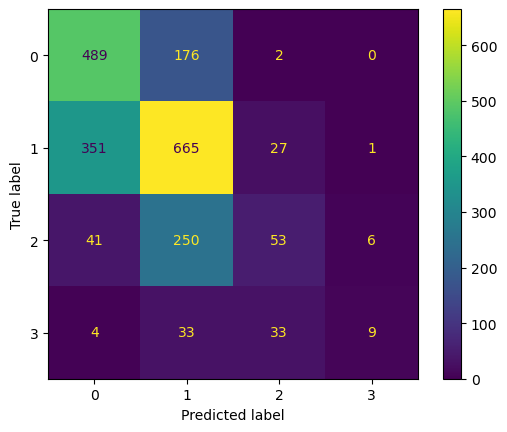

In [27]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto',random_state = 42))
clf.fit(X_train,y_train)
y_pred = clf.predict(X_val)
print('f1 score',f1_score(y_val, y_pred, average = 'macro'))
print('accuracy',accuracy_score(y_val, y_pred),'recall', recall_score(y_val, y_pred, average='macro'))
cm=confusion_matrix(y_val,y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.show()

### Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression

F1 SCORE:  0.37530499008824464
PRECISION: 0.449174794397171
RECALL: 0.36641039938138226
ACCURACY: 0.5504672897196262


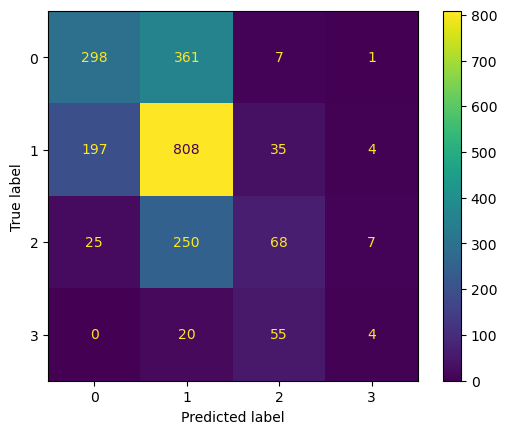

In [30]:
clf = make_pipeline(StandardScaler(), LogisticRegression(random_state=42, multi_class = 'multinomial',
                                                         solver = 'newton-cg',
                                                         n_jobs = -1))
clf.fit(X_train,y_train)
y_pred = clf.predict(X_val)
print('F1 SCORE: ',f1_score(y_val, y_pred, average = 'macro'))
print('PRECISION:',precision_recall_fscore_support(y_val, y_pred, average='macro')[0])
print('RECALL:',precision_recall_fscore_support(y_val, y_pred, average='macro')[1])
print('ACCURACY:', sum(y_pred == y_val)/len(y_val))
cm=confusion_matrix(y_val,y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.show()

### KNN

In [32]:
from sklearn.neighbors import KNeighborsClassifier

F1 SCORE:  0.44377398370086324
PRECISION: 0.5451408831045041
RECALL: 0.42072701443130156
ACCURACY: 0.5514018691588785


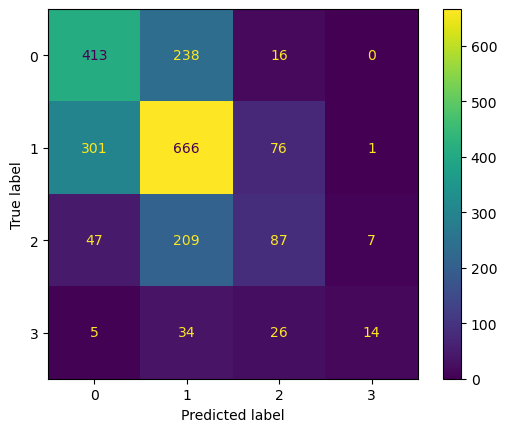

In [33]:
clf = make_pipeline(StandardScaler(),KNeighborsClassifier(n_jobs = -1) )
clf.fit(X_train,y_train)
y_pred = clf.predict(X_val)
print('F1 SCORE: ',f1_score(y_val, y_pred, average = 'macro'))
print('PRECISION:',precision_recall_fscore_support(y_val, y_pred, average='macro')[0])
print('RECALL:',precision_recall_fscore_support(y_val, y_pred, average='macro')[1])
print('ACCURACY:', sum(y_pred == y_val)/len(y_val))
cm=confusion_matrix(y_val,y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.show()

### Decision Tree Classifier

In [75]:
from sklearn.tree import DecisionTreeClassifier

F1 SCORE:  0.5445718983668641
PRECISION: 0.5523157838773175
RECALL: 0.5381562036944156
ACCURACY: 0.5934579439252337


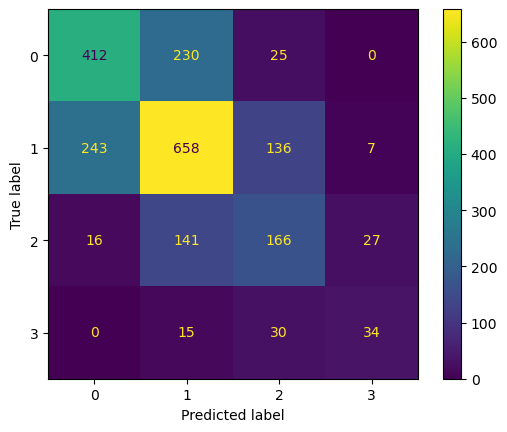

In [76]:
clf = make_pipeline(StandardScaler(),DecisionTreeClassifier(random_state = 42) )
clf.fit(X_train,y_train)
y_pred = clf.predict(X_val)
print('F1 SCORE: ',f1_score(y_val, y_pred, average = 'macro'))
print('PRECISION:',precision_recall_fscore_support(y_val, y_pred, average='macro')[0])
print('RECALL:',precision_recall_fscore_support(y_val, y_pred, average='macro')[1])
print('ACCURACY:', sum(y_pred == y_val)/len(y_val))
cm=confusion_matrix(y_val,y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.show()

### XGBoost

In [62]:
from xgboost import XGBClassifier

After a gridsearch over learning rate and n_estimator we found the best parameters were the ones below

In [63]:
xgb_params={'xgbclassifier__learning_rate': 0.3, 'xgbclassifier__n_estimators': 600}
xgb_params

{'xgbclassifier__learning_rate': 0.3, 'xgbclassifier__n_estimators': 600}

f1-score using XGBoost using MinMaxScaler:  0.6243253215664104
accuracy 0.6677570093457944 recall 0.6096385396813347


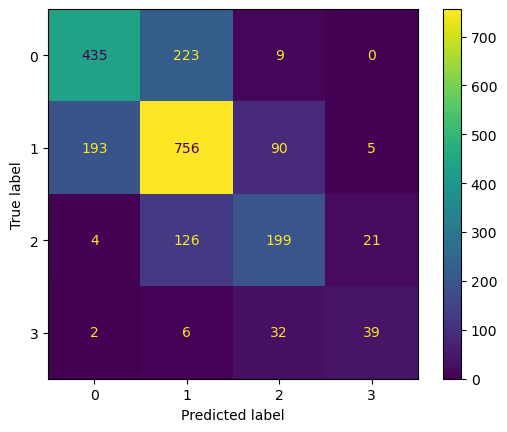

In [64]:
clf = make_pipeline(MinMaxScaler(), XGBClassifier(learning_rate=xgb_params['xgbclassifier__learning_rate'],n_estimators=xgb_params['xgbclassifier__n_estimators'],random_state=42))
clf.fit(X_train,y_train)
y_pred = clf.predict(X_val)
print('f1-score using XGBoost using MinMaxScaler: ',f1_score(y_val, y_pred, average = 'macro'))
print('accuracy',accuracy_score(y_val, y_pred),'recall', recall_score(y_val, y_pred, average='macro'))
cm=confusion_matrix(y_val,y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.show()

#### XGBOOST - One vs Rest Classifier - ORCO

In [42]:
from sklearn.multiclass import OneVsRestClassifier as ORC

In [45]:
clf=make_pipeline(MinMaxScaler(), XGBClassifier(learning_rate=xgb_params['xgbclassifier__learning_rate'],n_estimators=xgb_params['xgbclassifier__n_estimators'],random_state=42))
classifier=ORC(clf)
classifier.fit(X_train, y_train)

OneVsRestClassifier(estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                              ('xgbclassifier',
                                               XGBClassifier(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,
                                                             colsample_bytree=None,
                                                             early_stopping_rounds=None,
                                                             enable_categorical=False,
                                                             eval_metric=None,
                                                             gamma=None,
                                             

f1 score 0.6308186703437165
accuracy 0.6696261682242991 recall 0.6159125703875006


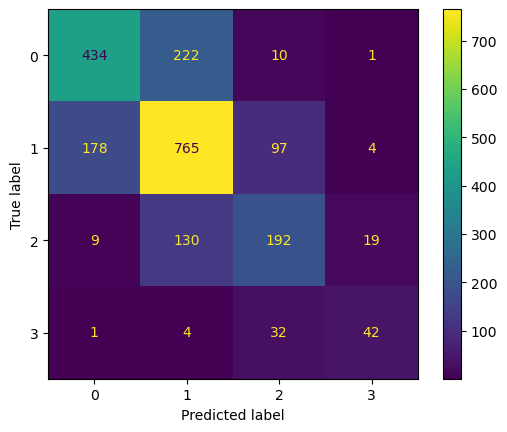

In [46]:
y_pred = classifier.predict(X_val)
print('f1 score',f1_score(y_val, y_pred, average = 'macro'))
print('accuracy',accuracy_score(y_val, y_pred),'recall', recall_score(y_val, y_pred, average='macro'))
cm=confusion_matrix(y_val,y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.show()

## Selected Models

Given their splendid results these algorithms were chosen to be discussed: Random Forest and Gradient Boosting.

As we will see their performances are very similar, however RF supports a very famous feature-importance approach: the SHapeley Addictive exPlanation, SHAP.
So for better interpretability of our results following each model we will run different feature importance approaches, the main sklearn one (based on feature permutation) for both of them and SHAP for RF. I will explain them below

+ Feature permutation for a variable is defined to be the mean decrease in the accuracy of the model when that very variable is shuffled in the structure of a tree ensemble algorithm
+ SHAP on the other hand represents the mean importance of each variable on the corresponding output of the model

### Random Forest

In [83]:
from sklearn.ensemble import RandomForestClassifier as RFC

After a gridsearch over criterion, max_features and n_estimator we found the best parameters were the ones below

In [84]:
rf_par={'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_features': None,
 'randomforestclassifier__n_estimators': 200}
rf_par

{'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_features': None,
 'randomforestclassifier__n_estimators': 200}

f1-score using Random Forest without scaling data:  0.6403099018440317
accuracy 0.6817757009345794 recall 0.6235468996966255


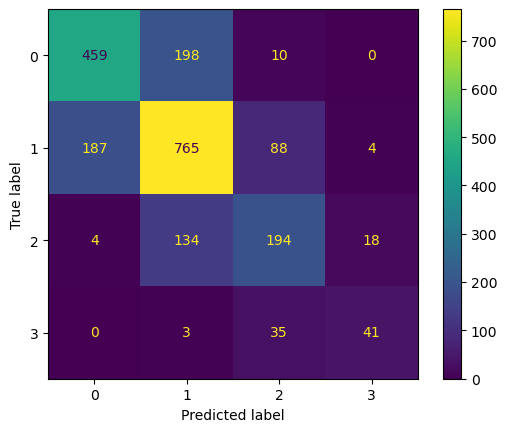

In [85]:
clf = make_pipeline(StandardScaler(), RFC(n_estimators=rf_par['randomforestclassifier__n_estimators'],criterion=rf_par['randomforestclassifier__criterion'],max_features=rf_par['randomforestclassifier__max_features'],random_state = 42))
clf.fit(X_train,y_train)
y_pred = clf.predict(X_val)
print('f1-score using Random Forest without scaling data: ',f1_score(y_val, y_pred, average = 'macro'))
print('accuracy',accuracy_score(y_val, y_pred),'recall', recall_score(y_val, y_pred, average='macro'))
cm=confusion_matrix(y_val,y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.show()

In [87]:
from sklearn.inspection import permutation_importance

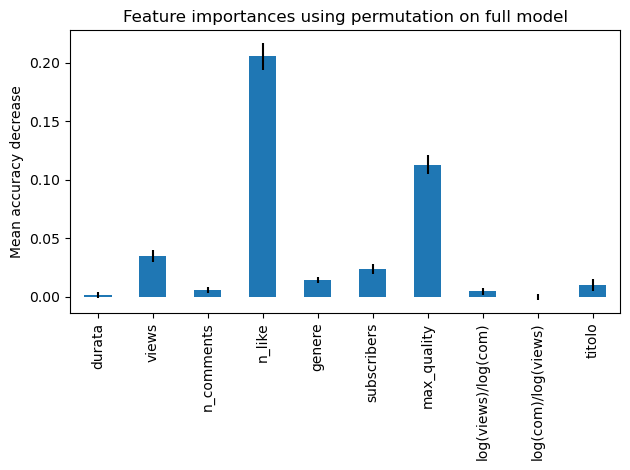

In [88]:
result = permutation_importance(
    clf, X_val, y_val, n_repeats=10, random_state=42, n_jobs=2)
forest_importances = pd.Series(result.importances_mean, index=X_val.columns)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()


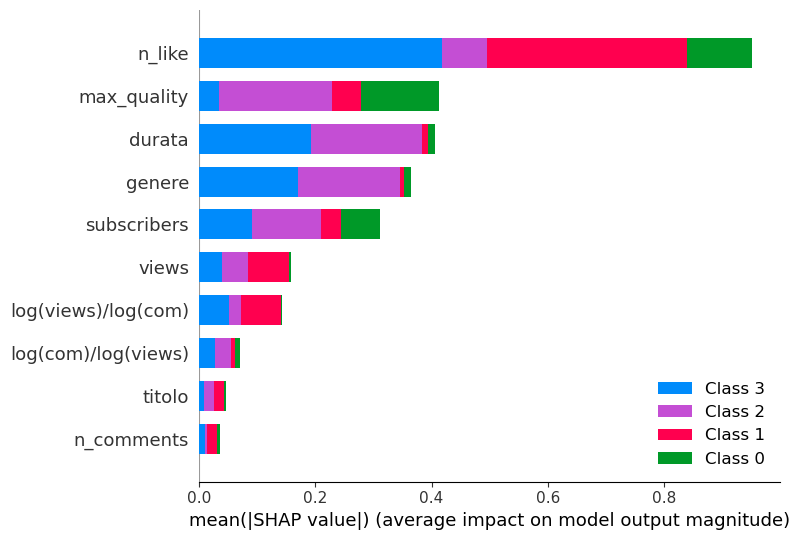

In [126]:
explainer=shap.TreeExplainer(clf[1][1])
shap_values = explainer.shap_values(X_val)
shap.summary_plot(shap_values, X_val, plot_type="bar")

As we can see the two variable importance explainer have not the same opinion, permutation gives more importance to views,likes and quality while SHAP finds out that durata and genere also impact on the output. For both it's however clear that the number of likes is the main variable for the algorithm

### Gradient Boosting

In [128]:
from sklearn.ensemble import GradientBoostingClassifier

After a gridsearch over learning rate, max_depth and n_estimator we found the best parameters were the ones below

In [129]:
gb_params={'gradientboostingclassifier__learning_rate': 0.25,
 'gradientboostingclassifier__max_depth': 3,
 'gradientboostingclassifier__n_estimators': 70}
gb_params

{'gradientboostingclassifier__learning_rate': 0.25,
 'gradientboostingclassifier__max_depth': 3,
 'gradientboostingclassifier__n_estimators': 70}

F1 SCORE:  0.6451357092779343
PRECISION: 0.6619457644544269
RECALL: 0.6311437560303634
ACCURACY: 0.688785046728972


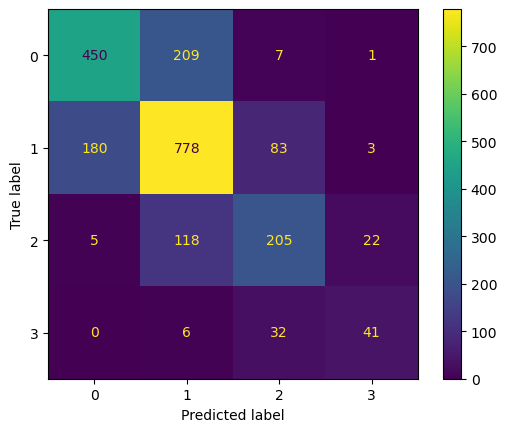

In [142]:
clf = make_pipeline(StandardScaler(), GradientBoostingClassifier(learning_rate=gb_params['gradientboostingclassifier__learning_rate'],n_estimators=gb_params['gradientboostingclassifier__n_estimators'],max_depth=gb_params['gradientboostingclassifier__max_depth'],random_state=42,loss='deviance'))
clf.fit(X_train,y_train)
y_pred = clf.predict(X_val)
precision_recall = precision_recall_fscore_support(y_val, y_pred, average='macro')
print('F1 SCORE: ',f1_score(y_val, y_pred, average = 'macro'))
print('PRECISION:',precision_recall[0])
print('RECALL:',precision_recall[1])
print('ACCURACY:', sum(y_pred == y_val)/len(y_val))
cm=confusion_matrix(y_val,y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.show()

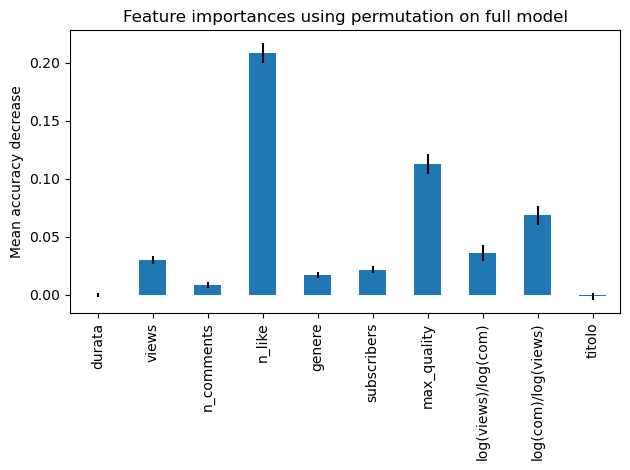

In [138]:
result = permutation_importance(
    clf, X_val, y_val, n_repeats=10, random_state=42, n_jobs=2)
forest_importances = pd.Series(result.importances_mean, index=X_val.columns)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()


The permutation explainer gives us almost the same results as the RF one, with the addition of the logaritmic features engineered that jump into third and fourth position.
However given the high uncertainty on this method, should we really trust it?

Further on we will try the OOC approach (happily renamed ORCO2 by our group) that further increases our accuracy up to 0.7 percent, however this approach does not allow us to extract any variable information.

#### One vs One Classifier (GB) - ORCO2

In [130]:
clf=make_pipeline(StandardScaler(), GradientBoostingClassifier(learning_rate=gb_params['gradientboostingclassifier__learning_rate'],n_estimators=gb_params['gradientboostingclassifier__n_estimators'],max_depth=gb_params['gradientboostingclassifier__max_depth'],random_state=42))
classifier=OOC(clf)
classifier.fit(X_train, y_train)

OneVsOneClassifier(estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('gradientboostingclassifier',
                                              GradientBoostingClassifier(learning_rate=0.25,
                                                                         n_estimators=70,
                                                                         random_state=42))]))

f1 score 0.6646510085722817
accuracy 0.6948598130841122 recall 0.6459549550119454


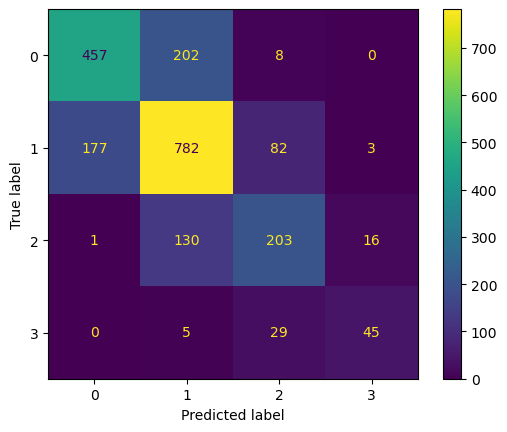

In [131]:
y_pred = classifier.predict(X_val)
print('f1 score',f1_score(y_val, y_pred, average = 'macro'))
print('accuracy',accuracy_score(y_val, y_pred),'recall', recall_score(y_val, y_pred, average='macro'))
cm=confusion_matrix(y_val,y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.show()

# Conclusions

We have used many algorithms to try and solve this problem. And we also reached a satisfying accuracy between 0.68 and 0.7, taking into consideration the very few information we had. At the end however the best model we would encourage to use in these kind of problems is the most interpretable one, and the random forest classifier allows for both accuracy and also interpretability thanks to the SHAP procedure.